In [36]:
import os
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


In [37]:
bevölkerung = pd.read_excel(f"Data\\12411-0012_complete.xlsx", index_col=0)

#read sterbefälle pro monat
sterbefälle_monat = pd.read_excel(f"Data\\sonderauswertung-sterbefaelle_groß.xlsx", sheet_name='D_2016-2022_Monate_AG_Ins') #Datensatz ist selbst zusammengebaut
sterbefälle_monat = sterbefälle_monat[sterbefälle_monat.columns].replace(["-",".","X "],0)
sterbefälle_monat

,Nr.,Jahr,Alter,Januar,Februar,März,April,Mai,Juni,Juli,August,September,Oktober,November,Dezember,Insgesamt
0,35,2020,Insgesamt,84980,80030,87396,83830,75835,72159,73795,78742,74243,79781,85989,108792,985572
1,36,2020,0-15,272,291,313,289,277,275,278,273,277,260,240,261,3306
2,37,2020,15-30,329,330,320,288,311,329,335,357,305,320,309,311,3844
3,38,2020,30-35,248,191,229,221,199,213,249,204,224,206,197,226,2607
4,39,2020,35-40,374,330,332,345,346,308,336,316,318,326,328,402,4061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,387,2000,75-80,12695,11668,10979,10282,10020,9795,9784,9956,9537,10346,10313,10911,126286
353,388,2000,80-85,10350,9692,8954,8351,8124,7919,8018,7948,7977,8702,8806,9370,104211
354,389,2000,85-90,15951,14812,13574,12355,11838,11343,11402,11365,11133,11863,12123,12829,150588
355,390,2000,90-95,9386,8742,7715,7130,6838,6863,6655,6894,6652,7409,7617,8126,90027


In [38]:
#Sterbefälle einteilen
#bildet summe aus gruppe 90-95 und gruppe ü 95, ersetzt die 90-95 row damit, benennt sie um und dropt die ü95 reihe.
new_row = (sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="90-95"]) + (sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="95 u. mehr"])
age_90_95 = sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="90-95"]
mehr_95 = sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="95 u. mehr"]

new_row = age_90_95.iloc[0,3:] + mehr_95.iloc[0,3:]
index_95 = list(age_90_95.index)
index_mehr = list(mehr_95.index)

for i in range (len(index_95)):
    new_row = age_90_95.iloc[i,3:] +mehr_95.iloc[i,3:]
    sterbefälle_monat.loc[index_95[i], "Januar":] = new_row
    sterbefälle_monat.drop(index_mehr[i], inplace=True)


sterbefälle_monat['Alter'].replace({'90-95': '90<'}, inplace = True)
sterbefälle_monat = sterbefälle_monat.rename(columns={'Januar': 1,'Februar': 2,'März': 3,'April': 4,'Mai': 5,'Juni': 6,'Juli': 7,'August': 8,'September': 9,'Oktober': 10,'November': 11,'Dezember': 12})


In [39]:
print(sterbefälle_monat.loc[sterbefälle_monat["Jahr"]==2020])
#print(sterbefälle_monat)

    Nr.  Jahr      Alter      1      2      3      4      5      6      7  \
0    35  2020  Insgesamt  84980  80030  87396  83830  75835  72159  73795   
1    36  2020       0-15    272    291    313    289    277    275    278   
2    37  2020      15-30    329    330    320    288    311    329    335   
3    38  2020      30-35    248    191    229    221    199    213    249   
4    39  2020      35-40    374    330    332    345    346    308    336   
5    40  2020      40-45    486    458    508    504    497    469    458   
6    41  2020      45-50    856    803    855    859    803    798    791   
7    42  2020      50-55   1943   1697   1878   1714   1737   1645   1710   
8    43  2020      55-60   3159   3002   3158   3029   3005   2902   2937   
9    44  2020      60-65   4414   4166   4454   4213   4150   3914   4107   
10   45  2020      65-70   5820   5520   6089   5638   5382   5155   5271   
11   46  2020      70-75   6653   6224   6893   6603   6134   5905   5895   

In [40]:
#alle Altersgruppen einteilen
rows = []
x = 0
j = 0
for k in range (1 ,32): 
    x=0
    for i in range(0, 92):
        k2 = k*91
        if i == 0 and k == 1:
            bevölkerungs_anzahl = bevölkerung.loc[bevölkerung.index[0]]["Gesamt"] #Gesamtbevölkerung je altersgruppe
        if i == 0 and k != 1:
            bevölkerungs_anzahl = bevölkerung.loc[bevölkerung.index[i+(k-1)*92]]["Gesamt"]
        else:
            bevölkerungs_anzahl = bevölkerung.loc[bevölkerung.index[i+((k-1)*92)]]["Gesamt"]

        if ( i < 15):
            x += bevölkerungs_anzahl
            if (i == 14):
                rows.append([1990+k-1,"0 - "+"<{}".format(i+1), x])
                x = 0   

        elif (i >= 15 and  i < 30):
    
            x += bevölkerungs_anzahl
            if i == 29:
                rows.append([1990+k-1,(str(i-14)+" - <"+str(i+1)), x])

            
                x = 0

        elif (i >= 30 and  i < 90):
            j += 1
            x += bevölkerungs_anzahl
            if j == 5:
                rows.append([1990+k-1,(str(i-4)+" - <"+str(i+1)), x])
                j = 0
                x = 0

        elif i == 90:
            x += bevölkerungs_anzahl
            rows.append([1990+k-1,"90=<", x])
            x = 0

        elif i == 91:
            x += bevölkerungs_anzahl
            rows.append([1990+k-1,"Gesamt", x])
            x=0
       
        

new_df = pd.DataFrame(rows, columns=["Jahr","Alter", "Anzahl"])

In [41]:
standard_bevölkerung = new_df.loc[new_df["Jahr"]==2020]
standard_bevölkerung

,Jahr,Alter,Anzahl
480,2020,0 - <15,11477800
481,2020,15 - <30,13340204
482,2020,30 - <35,5581088
483,2020,35 - <40,5290876
484,2020,40 - <45,5034888
485,2020,45 - <50,5035860
486,2020,50 - <55,6487224
487,2020,55 - <60,6817318
488,2020,60 - <65,5818137
489,2020,65 - <70,4899104


## Rohe Sterbedaten
Rohe Sterbedaten je Altersgruppe

In [42]:
#rohe sterberate
#loop über jahre
sterberaten_roh = []
for n in range(0,21):
    z = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2020-n)]
    sterberate_gesamt = 0

    # gesamt_bev = standard_bevölkerung.loc[standard_bevölkerung.index[15]][2]
    gesamt_bev = new_df.loc[new_df["Jahr"]==2020-n]["Anzahl"].reset_index(drop= True)

    #loop über altersgruppen
    for i in range(1,16):
        mri = ((z.loc[z.index[i]]["Insgesamt"]) / gesamt_bev[15]) * 100000  #sterberate je altersgruppe
        sterberate_gesamt += mri 


    sterberaten_roh.append([2020-n, sterberate_gesamt])
    sterberate_gesamt = 0

sterberaten_roh = pd.DataFrame(sterberaten_roh, columns=["Jahr", "Sterberate_Roh"])
sterberaten_roh

,Jahr,Sterberate_Roh
0,2020,1185.2223348940
1,2019,1129.6827645378
2,2018,1150.1843555178
3,2017,1126.0255189516
4,2016,1103.8302880336
5,2015,1125.8804976908
6,2014,1069.4363795789
7,2013,1106.6646973918
8,2012,1079.9075343564
9,2011,1061.0609763233


## Altersbereinigung der Daten
Als Standardbevölkerung wurde die Population aus dem Jahr 2020 verwendet


In [43]:
#altersbereinigt
sterberaten_bereinigt = []
#loop über jahre
for n in range(0,21):
    z = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2020-n)]
    q = new_df.loc[new_df["Jahr"]==2020-n]
    erg_sum = 0
    gesamt_bev = standard_bevölkerung.loc[standard_bevölkerung.index[15]][2]

    #loop über wochen
    sum = 0
    #loop über Altersgruppen
    for i in range(0,15):

        asx = standard_bevölkerung.loc[standard_bevölkerung.index[i]][2] #bevölkerung je altersgruppe Standardbevölkerung
        bevölkerung_grp = q.loc[q.index[i]][2] #größe Bevölkerungsruppe untersuchte Bevölkerung
        subx = ((z.loc[z.index[i+1]]["Insgesamt"]) / bevölkerung_grp) * 100000 #sterberate je altersgruppe
        sum += (asx * subx)    

    erg = sum / gesamt_bev
    erg_sum += erg

    #print(2020-n, "Altersbereinigt:",erg_sum)
    sterberaten_bereinigt.append([2020-n, erg_sum])

sterberaten_bereinigt = pd.DataFrame(sterberaten_bereinigt, columns=["Jahr", "Sterberate_bereinigt"])
sterberaten_bereinigt

,Jahr,Sterberate_bereinigt
0,2020,1185.2223348940
1,2019,1149.6736051968
2,2018,1197.3936287451
3,2017,1188.1074317455
4,2016,1179.4440928749
5,2015,1224.6695491937
6,2014,1173.9000831029
7,2013,1245.7842657022
8,2012,1234.3103174342
9,2011,1233.6024270876


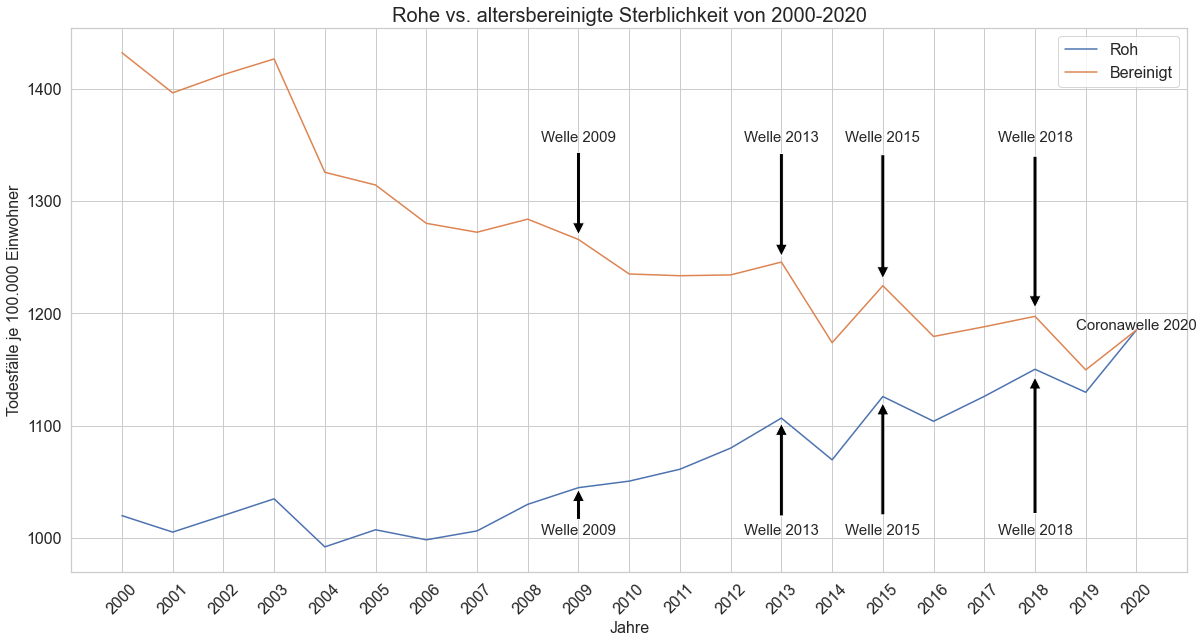

In [44]:
xticks = [i for i in range(2000,2021)]

ax = sns.lineplot(x="Jahr",  y='Sterberate_Roh', data=sterberaten_roh)
sns.lineplot(ax=ax, x="Jahr",  y='Sterberate_bereinigt', data=sterberaten_bereinigt)
plt.legend(labels=['Roh','Bereinigt'],fontsize= 16)
sns.set_theme(style="whitegrid")
plt.xticks(rotation=45)

# annotate lines
grippe_wellen = [2009,2013,2015,2018,2020]

for weave in grippe_wellen:
    sel_year_raw = sterberaten_roh.loc[sterberaten_roh["Jahr"] == weave]
    raw_year = sel_year_raw.Jahr
    raw_death = sel_year_raw.Sterberate_Roh

    sel_year_cleaned = sterberaten_bereinigt.loc[sterberaten_bereinigt["Jahr"] == weave]
    cleaned_year = sel_year_cleaned.Jahr
    cleaned_death = sel_year_cleaned.Sterberate_bereinigt
    if  weave == 2020:
     ax.annotate("Coronawelle " + str(weave), xy=(raw_year, raw_death),xycoords='data', size = 15,ha='center')
    else:
        ax.annotate("Welle "+str(weave), xy=(raw_year, raw_death), xycoords='data',xytext=(raw_year, 1000), size = 15,ha='center',arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left',
            verticalalignment='bottom')

        ax.annotate("Welle " +str(weave), xy=(cleaned_year, cleaned_death),xycoords='data',xytext=(cleaned_year, 1350),size = 15, ha='center',arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left',
            verticalalignment='bottom')

ax.set_ylabel("Todesfälle je 100.000 Einwohner", fontsize = 16)
ax.set_xlabel("Jahre", fontsize = 16)
ax.set_title("Rohe vs. altersbereinigte Sterblichkeit von 2000-2020",fontsize = 20)
plt.xticks(range(min(xticks), max(xticks)+1, 1), fontsize=16)
plt.yticks(fontsize=16)
# plt.ylabel("Sterberate je 100.000 Einwohner")
# plt.xticks(df_grippe_w.index, df_grippe_w["Alter"], rotation=45)
# plt.axis([0, 14, 0, 5000])
plt.gcf().set_size_inches(20, 10)

## Brerchnung der Comparative Mortality Ratio

In [45]:
cmr_df = pd.DataFrame(sterberaten_bereinigt, columns=["Jahr", "Sterberate_bereinigt"])
cmr_df["cmr"] = 0 # Damit Colum erzeugt wird
for i in range (len(cmr_df)):
    cmr_df["cmr"][i] = cmr_df["Sterberate_bereinigt"][i]/sterberaten_roh["Sterberate_Roh"][i]
cmr_df

C:\Users\mikes\AppData\Local\Temp\ipykernel_54468\3004264294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmr_df["cmr"][i] = cmr_df["Sterberate_bereinigt"][i]/sterberaten_roh["Sterberate_Roh"][i]


,Jahr,Sterberate_bereinigt,cmr
0,2020,1185.2223348940,1.0000000000
1,2019,1149.6736051968,1.0176959774
2,2018,1197.3936287451,1.0410449621
3,2017,1188.1074317455,1.0551336642
4,2016,1179.4440928749,1.0685012956
5,2015,1224.6695491937,1.0877438162
6,2014,1173.9000831029,1.0976810828
7,2013,1245.7842657022,1.1257106770
8,2012,1234.3103174342,1.1429777811
9,2011,1233.6024270876,1.1626121916


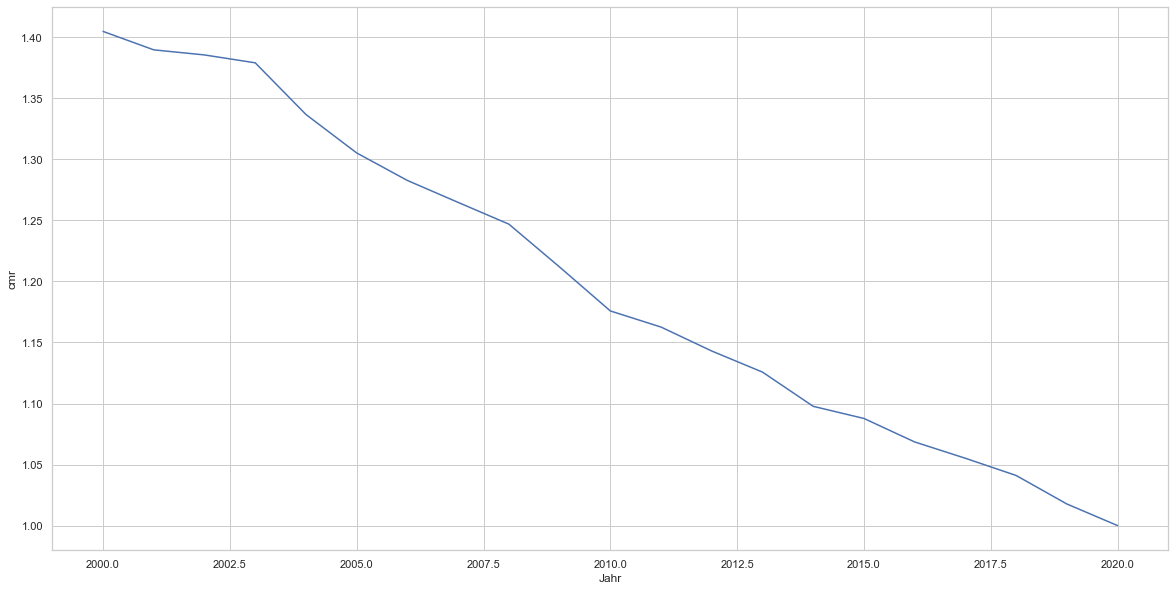

In [46]:
ax = sns.lineplot(x="Jahr",  y='cmr', data=cmr_df)
plt.gcf().set_size_inches(20, 10)

In [47]:
#Berechnung des Trendes
trend_area = cmr_df.loc[(cmr_df.Jahr >= 2017)]
trend_area = trend_area.sort_values(by="Jahr")
trend_area = trend_area.reset_index(drop=True)
trend_area

,Jahr,Sterberate_bereinigt,cmr
0,2017,1188.1074317455,1.0551336642
1,2018,1197.3936287451,1.0410449621
2,2019,1149.6736051968,1.0176959774
3,2020,1185.2223348940,1.0000000000


In [48]:
##Erstellen der Trendline
coeff = np.polyfit(trend_area.Jahr, trend_area.cmr ,1) # 1 = linear
m = coeff[0]
b = coeff[1]
print(m, b)

-0.018874997713469097 39.127651535537524


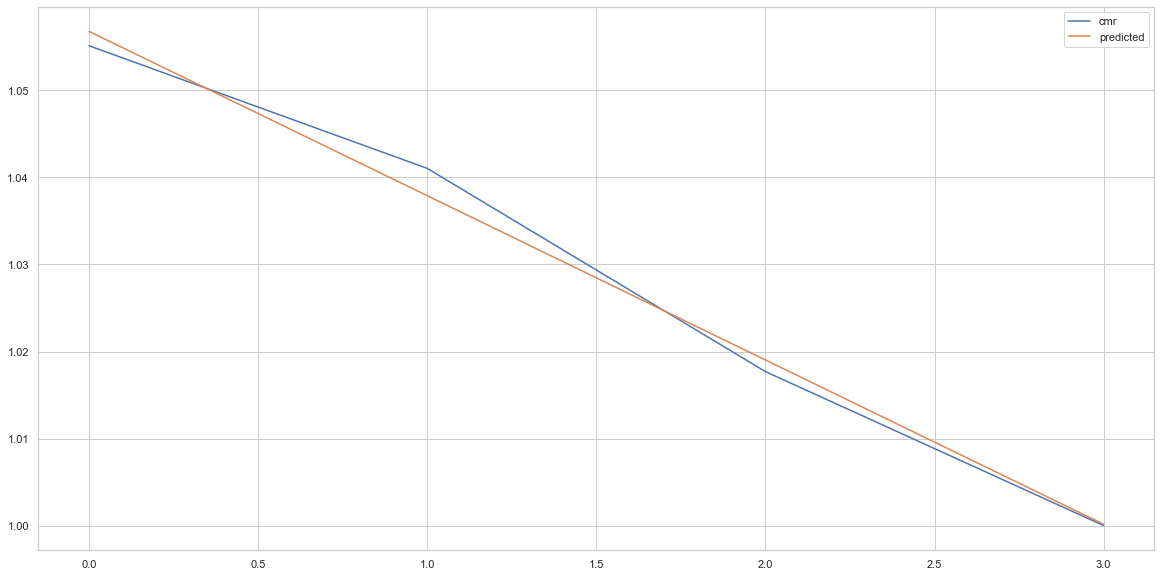

In [49]:
trend_area['predicted'] = pd.Series(np.polyval(coeff, trend_area.Jahr))

trend_area[['cmr', 'predicted']].plot()
plt.gcf().set_size_inches(20, 10)

In [50]:
cmr_df.loc[-1] = [2021, np.polyval(coeff, 2021)* cmr_df.loc[(cmr_df["Jahr"]==2020)]["Sterberate_bereinigt"][0], np.polyval(coeff, 2021)]  # adding a row
cmr_df.index = cmr_df.index + 1  # shifting index
cmr_df.sort_index(inplace=True)
cmr_df

,Jahr,Sterberate_bereinigt,cmr
0,2021.0000000000,1163.0363436324,0.9812811566
1,2020.0000000000,1185.2223348940,1.0000000000
2,2019.0000000000,1149.6736051968,1.0176959774
3,2018.0000000000,1197.3936287451,1.0410449621
4,2017.0000000000,1188.1074317455,1.0551336642
5,2016.0000000000,1179.4440928749,1.0685012956
6,2015.0000000000,1224.6695491937,1.0877438162
7,2014.0000000000,1173.9000831029,1.0976810828
8,2013.0000000000,1245.7842657022,1.1257106770
9,2012.0000000000,1234.3103174342,1.1429777811


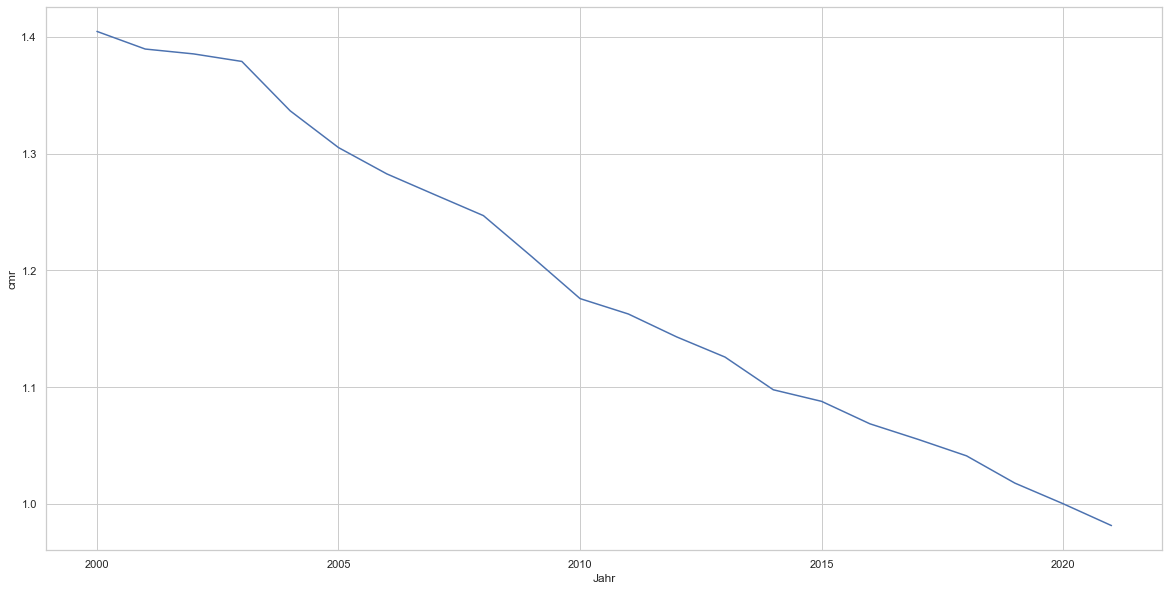

In [51]:
ax = sns.lineplot(x="Jahr",  y='cmr', data=cmr_df)
plt.gcf().set_size_inches(20, 10)

## Berechnung des Erwartungswerts

In [52]:
#Zugriff auf die Todesfälle ingesamt pro Jahr
df_tote =  new_df.loc[new_df.Alter == "Gesamt"][["Jahr", "Anzahl"]]
df_tote = df_tote.loc[df_tote.Jahr >1999].sort_values("Jahr",ascending=False).reset_index(drop= True)
df_tote

,Jahr,Anzahl
0,2020,83155031
1,2019,83166711
2,2018,83019213
3,2017,82792351
4,2016,82521653
5,2015,82175684
6,2014,81197537
7,2013,80767463
8,2012,80523746
9,2011,80327900


In [53]:
sterberaten_roh

,Jahr,Sterberate_Roh
0,2020,1185.2223348940
1,2019,1129.6827645378
2,2018,1150.1843555178
3,2017,1126.0255189516
4,2016,1103.8302880336
5,2015,1125.8804976908
6,2014,1069.4363795789
7,2013,1106.6646973918
8,2012,1079.9075343564
9,2011,1061.0609763233


In [54]:
#Todesfälle altersbereinigt und roh

sterberaten_bereinigt["Todesfälle_altersbereinigt"] = (sterberaten_bereinigt.Sterberate_bereinigt/100000) * df_tote.Anzahl
sterberaten_bereinigt["Todesfälle_rohe"] = (sterberaten_roh.Sterberate_Roh/100000) * df_tote.Anzahl
pd.options.display.float_format = '{:.10f}'.format
sterberaten_bereinigt

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe
0,2020,1185.2223348940,985572.0000000000,985572.0000000000
1,2019,1149.6736051968,956145.7246772698,939519.9999999999
2,2018,1197.3936287451,994066.7670963550,954874.0000000000
3,2017,1188.1074317455,983662.0751478324,932262.9999999999
4,2016,1179.4440928749,973296.7616512571,910899.0000000000
5,2015,1224.6695491937,1006380.5787896229,925199.9999999999
6,2014,1173.9000831029,953177.9543204965,868356.0000000001
7,2013,1245.7842657022,1006188.3458608260,893825.0000000000
8,2012,1234.3103174342,993912.9048625464,869582.0000000000
9,2011,1233.6024270876,990926.9240285283,852328.0000000000


In [55]:
#Split in train und Test
lm_test_df = sterberaten_bereinigt.loc[(sterberaten_bereinigt["Jahr"] > 2008) & (sterberaten_bereinigt["Jahr"] < 2020 )]
lm_test_df

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe
1,2019,1149.6736051968,956145.7246772698,939519.9999999999
2,2018,1197.3936287451,994066.7670963550,954874.0000000000
3,2017,1188.1074317455,983662.0751478324,932262.9999999999
4,2016,1179.4440928749,973296.7616512571,910899.0000000000
5,2015,1224.6695491937,1006380.5787896229,925199.9999999999
6,2014,1173.9000831029,953177.9543204965,868356.0000000001
7,2013,1245.7842657022,1006188.3458608260,893825.0000000000
8,2012,1234.3103174342,993912.9048625464,869582.0000000000
9,2011,1233.6024270876,990926.9240285283,852328.0000000000
10,2010,1235.1500020187,1009754.9137532924,858768.0000000000


In [56]:
#Datensatz aufbereiten
df = lm_test_df.copy()
df = df.sort_values('Jahr')
df = df.reset_index(drop= True)
df

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe
0,2009,1265.8937671366,1035529.6727400314,854543.9999999999
1,2010,1235.1500020187,1009754.9137532924,858768.0000000000
2,2011,1233.6024270876,990926.9240285283,852328.0000000000
3,2012,1234.3103174342,993912.9048625464,869582.0000000000
4,2013,1245.7842657022,1006188.3458608260,893825.0000000000
5,2014,1173.9000831029,953177.9543204965,868356.0000000001
6,2015,1224.6695491937,1006380.5787896229,925199.9999999999
7,2016,1179.4440928749,973296.7616512571,910899.0000000000
8,2017,1188.1074317455,983662.0751478324,932262.9999999999
9,2018,1197.3936287451,994066.7670963550,954874.0000000000


In [57]:
##Erstellen der Trendline
coeff_2021 = np.polyfit(df.Jahr, df.Todesfälle_altersbereinigt ,1) # 1 = linear
m_2021 = coeff_2021[0]
b_2021 = coeff_2021[1]
print(m_2021, b_2021)

-4750.062973431246 10557812.521483986


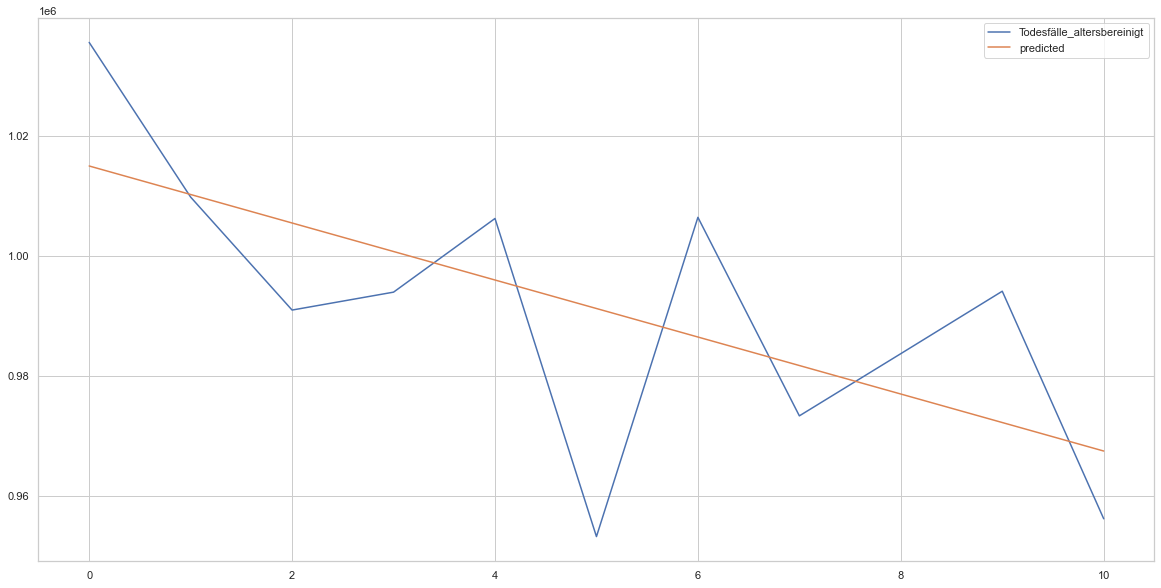

In [58]:
df['predicted'] = pd.Series(np.polyval(coeff_2021, df.Jahr))
df[['Todesfälle_altersbereinigt', 'predicted']].plot()
plt.gcf().set_size_inches(20, 10)

In [59]:
pred_totesfaelle = np.polyval(coeff_2021, 2020)  # adding a row
pred_totesfaelle

962685.3151528686

In [60]:
#Erwarteten Todesfälle
erwartungswerte = []

for idx in range(1999,2010,1):
    temp_df = sterberaten_bereinigt.loc[(sterberaten_bereinigt["Jahr"] > idx) & (sterberaten_bereinigt["Jahr"] < idx+11)]
    coeff_temp = np.polyfit(temp_df.Jahr, temp_df.Todesfälle_altersbereinigt ,1) # 1 = linear
    m_temp = coeff_temp[0]
    b_temp = coeff_temp[1]
    erwartungswerte.append([idx+12,np.polyval(coeff_2021, idx+12)])

df_erwartungswerte = pd.DataFrame(erwartungswerte, columns=["Jahr", "Erwartete Todesfälle"])
df_erwartungswerte

,Jahr,Erwartete Todesfälle
0,2011,1005435.8819137495
1,2012,1000685.8189403191
2,2013,995935.7559668869
3,2014,991185.6929934565
4,2015,986435.6300200243
5,2016,981685.5670465939
6,2017,976935.5040731616
7,2018,972185.4410997313
8,2019,967435.3781262990
9,2020,962685.3151528686


In [61]:
df_2011_bis_2020 = sterberaten_bereinigt.loc[sterberaten_bereinigt.Jahr > 2010].sort_values("Jahr").reset_index(drop=True)
df_2011_bis_2020["Delta_erwartet_altersbereinigt"] = df_2011_bis_2020["Todesfälle_altersbereinigt"] - df_erwartungswerte["Erwartete Todesfälle"]
df_2011_bis_2020

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe,Delta_erwartet_altersbereinigt
0,2011,1233.6024270876,990926.9240285283,852328.0000000000,-14508.9578852212
1,2012,1234.3103174342,993912.9048625464,869582.0000000000,-6772.9140777728
2,2013,1245.7842657022,1006188.3458608260,893825.0000000000,10252.5898939391
3,2014,1173.9000831029,953177.9543204965,868356.0000000001,-38007.7386729600
4,2015,1224.6695491937,1006380.5787896229,925199.9999999999,19944.9487695986
5,2016,1179.4440928749,973296.7616512571,910899.0000000000,-8388.8053953368
6,2017,1188.1074317455,983662.0751478324,932262.9999999999,6726.5710746708
7,2018,1197.3936287451,994066.7670963550,954874.0000000000,21881.3259966237
8,2019,1149.6736051968,956145.7246772698,939519.9999999999,-11289.6534490292
9,2020,1185.2223348940,985572.0000000000,985572.0000000000,22886.6848471314


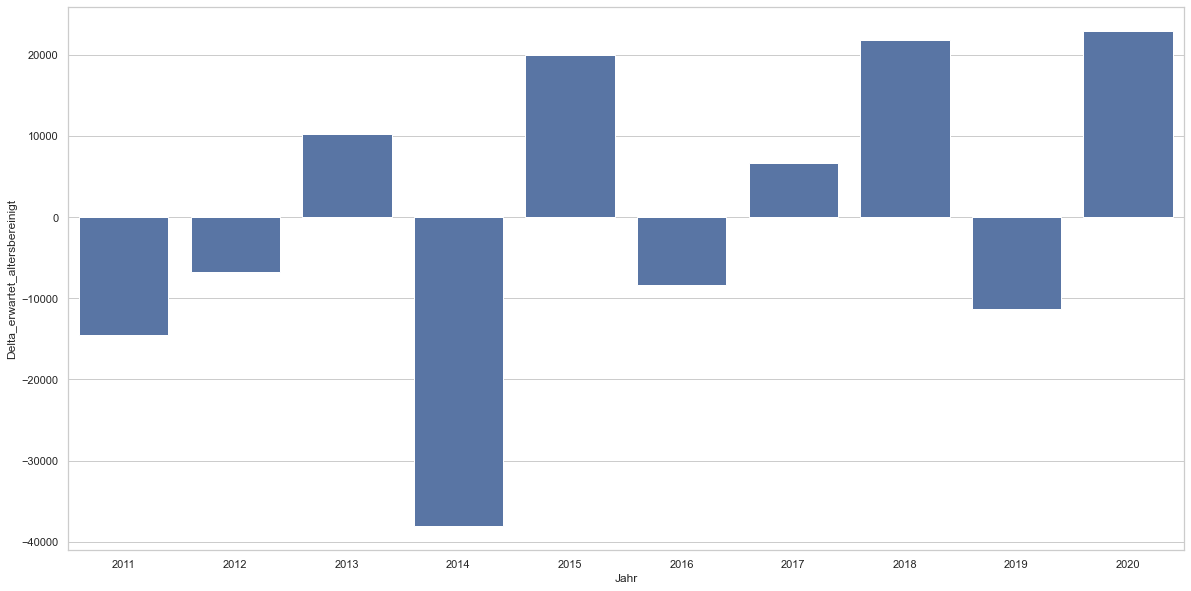

In [62]:
sns.barplot(data = df_2011_bis_2020, x= "Jahr", y = "Delta_erwartet_altersbereinigt", color = 'b')
plt.gcf().set_size_inches(20, 10)